In [ ]:
!pip install facenet-pytorch  # Install facenet-pytorch for face detection and alignment

In [ ]:
!pip install torchvision  # Install torchvision for image transformations

In [ ]:
!pip install --upgrade pillow  # Upgrade Pillow to ensure compatibility with image processing

In [10]:
# Face Recognition with Cosine Similarity Matching
# =================================================
# Well-documented notebook for evaluating face recognition on distorted images
# using a pretrained model (InceptionResnetV1 from facenet-pytorch).
#
# Requirements:
# - facenet-pytorch
# - torch, torchvision
# - sklearn
# - numpy, pillow, matplotlib

import os
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from facenet_pytorch import InceptionResnetV1, MTCNN
from torchvision import transforms
import torch

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
train_dir = "./train"
val_dir = "./val"  # Change this path to test dataset as needed

# Load FaceNet
facenet = InceptionResnetV1(pretrained='vggface2', classify=False).eval().to(device)
mtcnn = MTCNN(image_size=160, margin=20, keep_all=False, device=device)


In [12]:
# Test-Time Augmentation (TTA)
def tta_embeddings(img):
    faces = []
    enhancers = [
        lambda x: x,
        lambda x: ImageEnhance.Brightness(x).enhance(1.2),
        lambda x: ImageEnhance.Sharpness(x).enhance(2.0),
        lambda x: ImageEnhance.Contrast(x).enhance(1.5)
    ]
    for enhance in enhancers:
        aug_img = enhance(img)
        face = mtcnn(aug_img)
        if face is not None:
            with torch.no_grad():
                emb = facenet(face.unsqueeze(0).to(device))
                faces.append(emb.squeeze().cpu().numpy())
    return faces

# Get average TTA embedding
def get_embedding(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        embs = tta_embeddings(img)
        if embs:
            return np.mean(embs, axis=0)
        return None
    except:
        return None

In [13]:
# Build validation feature database from clean images
val_features = {}
print("\n📂 Building Val Feature DB:")
for person in tqdm(os.listdir(val_dir)):
    person_path = os.path.join(val_dir, person)
    if not os.path.isdir(person_path):
        continue

    for file in os.listdir(person_path):
        file_path = os.path.join(person_path, file)
        if os.path.isdir(file_path):  # skip "distortion"
            continue

        embedding = get_embedding(file_path)
        if embedding is not None:
            val_features.setdefault(person, []).append(embedding)



📂 Building Val Feature DB:


100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


In [14]:
# Match distorted images
results = []
similarity_scores = []
print("\n🔍 Matching distorted images:")
for person in tqdm(os.listdir(val_dir)):
    distortion_path = os.path.join(val_dir, person, "distortion")
    if not os.path.isdir(distortion_path):
        continue

    for file in os.listdir(distortion_path):
        file_path = os.path.join(distortion_path, file)
        embedding = get_embedding(file_path)
        if embedding is None:
            continue

        best_person = None
        best_score = -1

        for known_person, embeddings in val_features.items():
            sims = cosine_similarity([embedding], embeddings)
            max_sim = np.max(sims)
            if max_sim > best_score:
                best_score = max_sim
                best_person = known_person

        match = 1 if best_person == person and best_score > 0.65 else 0
        results.append((file, person, best_person, best_score, match))
        similarity_scores.append(best_score)



🔍 Matching distorted images:


100%|██████████| 250/250 [18:08<00:00,  4.35s/it]


In [15]:
# Output sample results
print("\n📊 Sample Results (first 10):")
for r in results[:10]:
    print(f"{r[0]} | True: {r[1]} | Predicted: {r[2]} | Similarity: {r[3]:.4f} | Match: {r[4]}")

# Evaluation
true_labels = [r[1] for r in results]
pred_labels = [r[2] if r[4] == 1 else "wrong" for r in results]
valid_results = [r for r in results if r[4] == 1]
true_valid = [r[1] for r in valid_results]
pred_valid = [r[2] for r in valid_results]

top1_acc = accuracy_score(true_labels, pred_labels)
macro_f1 = f1_score(true_valid, pred_valid, average='macro') if true_valid else 0.0

print(f"\n✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Macro-Averaged F1 Score: {macro_f1:.4f}")



📊 Sample Results (first 10):
Kai-Uwe_Ricke_0001_foggy.jpg | True: Kai-Uwe_Ricke | Predicted: Kai-Uwe_Ricke | Similarity: 0.9191 | Match: 1
Kai-Uwe_Ricke_0001_rainy.jpg | True: Kai-Uwe_Ricke | Predicted: Kai-Uwe_Ricke | Similarity: 0.6729 | Match: 1
Kai-Uwe_Ricke_0001_resized.jpg | True: Kai-Uwe_Ricke | Predicted: Kai-Uwe_Ricke | Similarity: 0.9743 | Match: 1
Kai-Uwe_Ricke_0001_noisy.jpg | True: Kai-Uwe_Ricke | Predicted: Kai-Uwe_Ricke | Similarity: 0.6907 | Match: 1
Kai-Uwe_Ricke_0001_lowlight.jpg | True: Kai-Uwe_Ricke | Predicted: Kai-Uwe_Ricke | Similarity: 0.9616 | Match: 1
Kai-Uwe_Ricke_0001_blurred.jpg | True: Kai-Uwe_Ricke | Predicted: Kai-Uwe_Ricke | Similarity: 0.8748 | Match: 1
Hans_Eichel_0001_noisy.jpg | True: Hans_Eichel | Predicted: Hans_Eichel | Similarity: 0.6230 | Match: 0
Hans_Eichel_0001_blurred.jpg | True: Hans_Eichel | Predicted: Hans_Eichel | Similarity: 0.8123 | Match: 1
Hans_Eichel_0003_foggy.jpg | True: Hans_Eichel | Predicted: Hans_Eichel | Similarity: 0.9378 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Threshold tuning
SIMILARITY_THRESHOLD = 0.65  # Initial threshold based on observations

def threshold_curve(results, thresholds=np.linspace(0.3, 0.95, 50)):
    acc_list, f1_list = [], []

    for thresh in thresholds:
        y_true = [r['true'] for r in results]
        y_pred = [
            r['pred'] if (r['score'] > thresh and r['pred'] == r['true']) else "wrong"
            for r in results
        ]
        valid = [
            r for r in results if r['score'] > thresh and r['pred'] == r['true']
        ]
        true_valid = [r['true'] for r in valid]
        pred_valid = [r['pred'] for r in valid]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(true_valid, pred_valid, average='macro', zero_division=0)

        acc_list.append(acc)
        f1_list.append(f1)

    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")
    plt.plot(thresholds, acc_list, label="Top-1 Accuracy", color='darkorange', marker='o')
    plt.plot(thresholds, f1_list, label="Macro F1 Score", color='teal', marker='s')
    plt.axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--', label='Current Threshold')
    plt.xlabel("Similarity Threshold")
    plt.ylabel("Score")
    plt.title("Threshold Tuning Curve")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

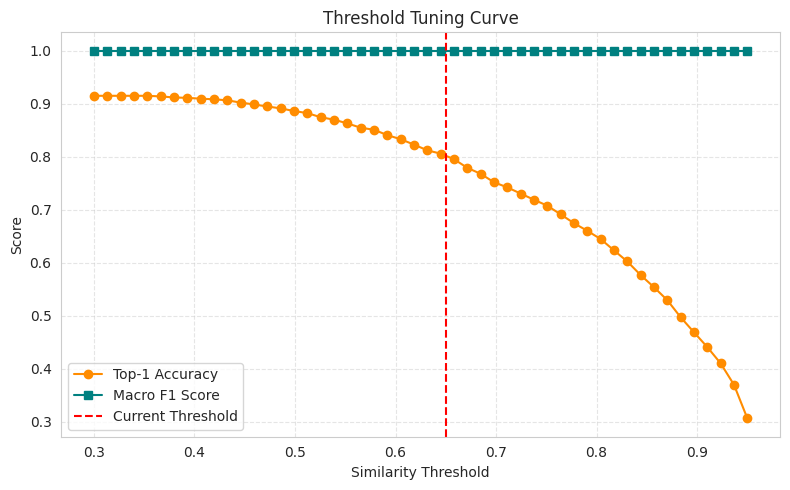

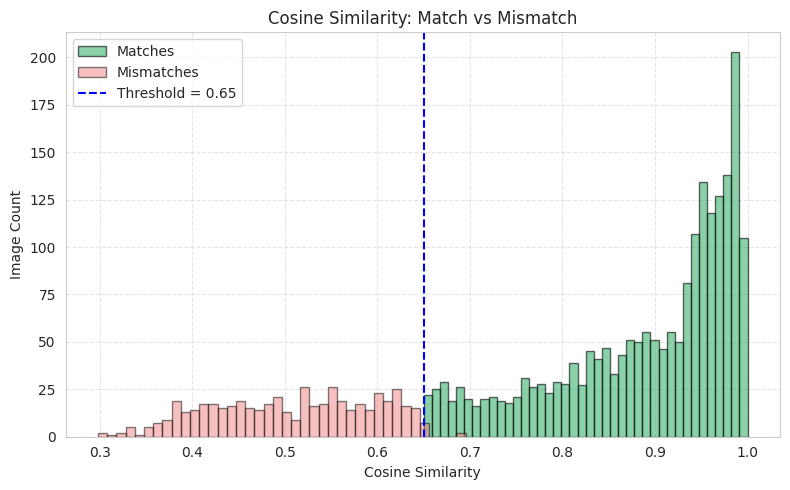

In [ ]:
# Prepare results in dict format for plotting
structured_results = [
    {'file': r[0], 'true': r[1], 'pred': r[2], 'score': r[3], 'match': r[4]}
    for r in results
]

# Plot threshold tuning curve
threshold_curve(structured_results)

# Plot cosine similarity histogram
match_scores = [r['score'] for r in structured_results if r['match'] == 1]
mismatch_scores = [r['score'] for r in structured_results if r['match'] == 0]

plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
plt.hist(match_scores, bins=40, alpha=0.6, label="Matches", color='mediumseagreen', edgecolor='black')
plt.hist(mismatch_scores, bins=40, alpha=0.5, label="Mismatches", color='lightcoral', edgecolor='black')
plt.axvline(SIMILARITY_THRESHOLD, color='blue', linestyle='--', label=f'Threshold = {SIMILARITY_THRESHOLD}')
plt.title("Cosine Similarity: Match vs Mismatch")
plt.xlabel("Cosine Similarity")
plt.ylabel("Image Count")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


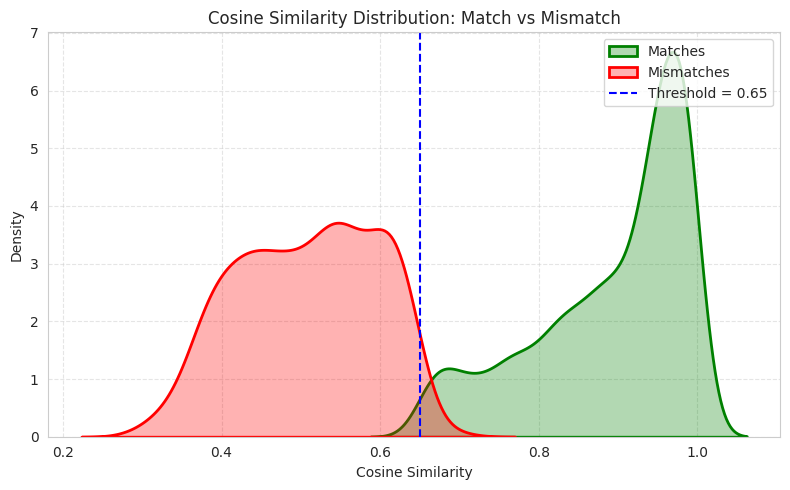

In [ ]:
# KDE plot for match vs mismatch
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
sns.kdeplot(match_scores, label='Matches', color='green', linewidth=2, fill=True, alpha=0.3)
sns.kdeplot(mismatch_scores, label='Mismatches', color='red', linewidth=2, fill=True, alpha=0.3)
plt.axvline(SIMILARITY_THRESHOLD, color='blue', linestyle='--', label=f'Threshold = {SIMILARITY_THRESHOLD}')
plt.title("Cosine Similarity Distribution: Match vs Mismatch")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
